In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch import nn

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [2]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [3]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [32]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        time= 1500
        batch = 32
        
        self.lstm_unit = 128
        self.karnel= 3
        self.stride = 5
        feat = [120, 118, 256, 88]

        #self.layers = [ nn.Conv1d( 1500, 1500, kernel_size) ] #, nn.ReLU()]
        self.convo1 = nn.Conv1d( 116, 100, 3, padding='valid')
        self.convo2 = nn.Conv1d( 1500, 1000, 5, padding='valid')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=100, hidden_size=44, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=998, hidden_size=128, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(998,1500 , bias=True)

    def __call__(self, x):
        x = self.convo2(x)
        x=torch.transpose(x, 0, 1)
        x = self.convo1(x) 

        x = self.relu(x)
        x = x+1
        x = torch.log(x)
       
        #x, _ = self.lstm2(x)
        x = self.linear(x)
        x=torch.transpose(x, 0, 1)
        x, _ = self.lstm(x)
        x = normalized(x)

        return x

def normalize(x, m, s): 
    return (x-m)/s

class GetLSTMOutput(nn.Module):
        def forward(self, x):
            out, _ = x
            return out

In [22]:
x,y = next(iter(train))

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
xy =model(x[0])
temp=x[0]
ans_temp=xy

In [40]:
loss_f = nn.MSELoss()
def normalized(data): 
    return (data - data.min()) / (data.max()-data.min())

def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    correct = (predictions >= 0.5) == true_values
    return correct.mean().item()

    predictions = (predictions >=0.5) 
    correct = ((predictions >=0.5) == true_values)
    return correct.mean().item()

def M_loss_func(yhat,y):
    '''
    predictions = yhat
    true_values = ((1/2)*y )+0.5
    '''
    temp = torch.ones(1500, 88 , requires_grad=True) / 2
    predictions = yhat
    true_values = y
    return loss_f(true_values, predictions)

## loop

In [35]:
from torch.utils.data import DataLoader
batch = 16
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)
epoch = len(train)

In [42]:
def get_epoch(k):
    print("epoch","\t train loss \t accuracy \t\t val loss")
    train_loss ,train_acc, val_loss=0,0,0
    for i in range(0,k) :
        train_epoch(i)

def train_epoch(k):
    x,y =next(iter(train))
    train_batch_loss = []
    train_batch_acc = []
    for i in range(batch) :
        xb=x[i]
        yb=y[i]
        
        yhatb = model(xb)
        loss = M_loss_func(yhatb, yb)
        acc = M_accuracy(yhatb, yb)
        
        train_batch_loss.append(loss.detach().cpu().numpy())
        train_batch_acc.append(acc)
        #baseline_mse = nn.MSELoss()(torch.zeros_like(yb), yb)
        baseline_mse = M_loss_func(torch.zeros_like(yb), yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy()),metrics.append(acc)
        baseline.append(baseline_mse)  

    train_loss = np.mean(train_batch_loss)  # average train loss among all batches
    train_acc = np.mean(train_batch_acc)  # average acc among all batches     

    val_batch_loss = []
    xx,yy =next(iter(test))
    for i in range(batch) :
        xb=xx[i]
        yb=yy[i]
        
        # we don't need to calculate gradients when evaluating
        with torch.no_grad():
            yhatb = model(xb)  # forward propagation
            loss = M_loss_func(yhatb, yb)  # compute val loss
        val_batch_loss.append(loss.cpu().numpy())
    
    val_loss = np.mean(val_batch_loss)
    print(k, "\t", train_loss , "\t", train_acc,"\t", val_loss, "\t" , yhatb.mean())

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)
#model.load_state_dict(torch.load("weight/convo1/mymodel.pt"))

In [43]:
losses, metrics, baseline = [], [], []

#optimizer = torch.optim.SGD(model.parameters(), lr=10e-4/2./2/2/2/2, momentum=0.95)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
#model=Model()
#model.load_state_dict(torch.load("weight/convo1/mymodel.pt"))
get_epoch(25)
torch.save(model.state_dict(), "weight/convo1/mymodel.pt")

epoch 	 train loss 	 accuracy 		 val loss
0 	 0.20716925 	 0.7589715909090909 	 0.22008072 	 tensor(0.4513)
1 	 0.2144171 	 0.7110875946969697 	 0.21668017 	 tensor(0.4466)
2 	 0.22025138 	 0.6882002840909092 	 0.21894254 	 tensor(0.4573)
3 	 0.22577052 	 0.6683295454545455 	 0.24534783 	 tensor(0.4843)
4 	 0.2317349 	 0.6501169507575757 	 0.22335339 	 tensor(0.4508)
5 	 0.22169495 	 0.689780303030303 	 0.21554846 	 tensor(0.4446)
6 	 0.21290295 	 0.7162589962121211 	 0.20425525 	 tensor(0.4251)
7 	 0.20763543 	 0.7310572916666667 	 0.20511101 	 tensor(0.4340)
8 	 0.19966985 	 0.7530743371212121 	 0.19437486 	 tensor(0.4146)
9 	 0.18724966 	 0.7886027462121212 	 0.18412119 	 tensor(0.3993)
10 	 0.18351074 	 0.7980018939393939 	 0.18085787 	 tensor(0.3985)
11 	 0.1761222 	 0.8156860795454546 	 0.17050558 	 tensor(0.3754)
12 	 0.16676335 	 0.8391377840909091 	 0.16292307 	 tensor(0.3655)
13 	 0.15763965 	 0.8603091856060606 	 0.15334421 	 tensor(0.3530)
14 	 0.14968747 	 0.87610937500000

In [13]:
with open('weight/convo1/baseline_log.pkl', 'rb') as f:
    baseline_log = pickle.load(f)
with open('weight/convo1/loss_log.pkl', 'rb') as f:
    loss_log = pickle.load(f)
with open('weight/convo1/acc_log.pkl', 'rb') as f:
    acc_log = pickle.load(f)
with open('weight/convo1/lr_log.pkl', 'rb') as f:
    lr_log = pickle.load(f)

## Graph Represent

In [72]:
for k in losses :
    loss_log.append(float(k))
for i in range(len(baseline)) :
    lr_log.append(lr)
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

In [44]:
lr=10e-4/2./2/2/2/2
acc_log=[]
baseline_log=[]
loss_log=[]
lr_log=[]

for k in losses :
    loss_log.append(float(k))
for i in range(len(baseline)) :
    lr_log.append(lr)
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

<ipython-input-45-867ec72a6036>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


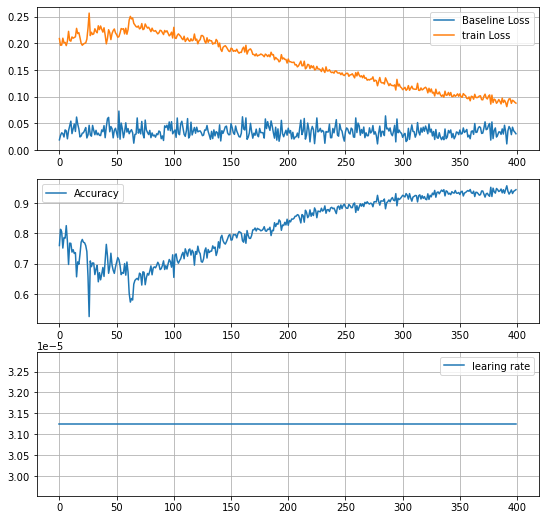

In [45]:
x = torch.arange(len(acc_log)).numpy()
fig,ax = plt.subplots(3,1,figsize=(9, 9))

#0 = loss & baseline
#1 = Accuracy
#2 = learing rate

ax[0].plot(x, baseline_log, label="Baseline Loss")
ax[0].plot(x, loss_log, label="train Loss")
ax[1].plot(x, acc_log, label="Accuracy")
ax[2].plot(x, lr_log, label="learing rate")

for k in ax :
    k.legend()
    k.grid(True)


fig.show()

In [27]:
with open('weight/convo1/baseline_log.pkl', 'wb') as f:
    pickle.dump(baseline_log, f)
with open('weight/convo1/loss_log.pkl', 'wb') as f:
    pickle.dump(loss_log, f)
with open('weight/convo1/acc_log.pkl', 'wb') as f:
    pickle.dump(acc_log, f)
with open('weight/convo1/lr_log.pkl', 'wb') as f:
    pickle.dump(lr_log, f)

## TEST

In [46]:
batch = 16
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [47]:
def get_test_epoch(k):
    for i in range(0,k) :
        test_epoch()

def test_epoch():
    x,y =next(iter(test))
    for i in range(batch) :
        xb=x[i]
        yb=y[i]
        yhatb = model(xb)
        acc = M_accuracy(yhatb, yb)    
        metrics_test.append(acc)

In [48]:
metrics_test=[]
get_test_epoch(10)

In [49]:
print( "accuracy : ", sum(metrics_test)/len(metrics_test))

accuracy :  0.9402258522727271


In [79]:
x,y = next(iter(test))
xy=model(x[0])

In [62]:
tx = xy.detach().numpy()
ty = y[0].detach().numpy()
tx = 1*(tx>=0.5)

In [63]:
check = 1*(tx==ty)
check[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [65]:
check.mean()

0.950939393939394

In [69]:
len(tx)

1500

In [ ]:
fig,ax = plt.subplots(2,1)
k = torch.transpose(xy, 0,1)
ax[0].imshow(k)
ky = torch.transpose(ty, 1, 2)
ax[1].imshow(ky)
plt.show()

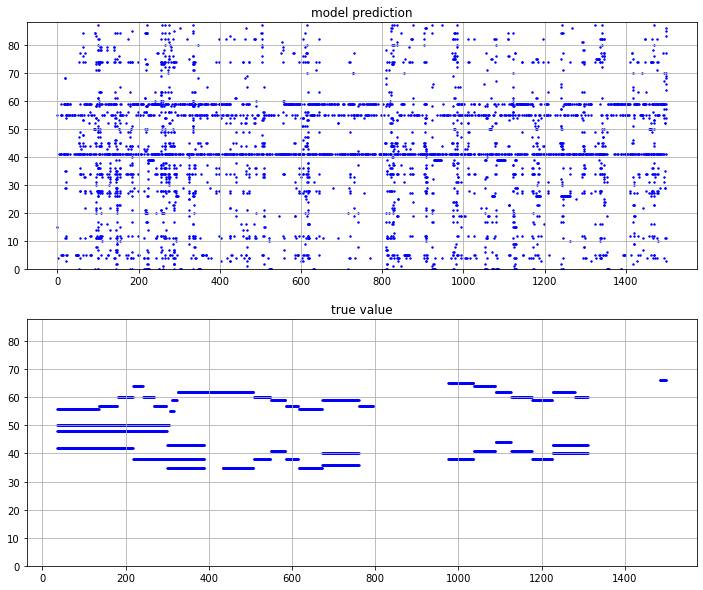

In [82]:
id=0
x=np.arange(0,len(tx[id]))
fig,ax = plt.subplots(2,1)
ax[0].grid(), ax[1].grid()
ax[0].set_ylim(0, 88)
ax[1].set_ylim(0, 88)

fig.set_figwidth(12)
fig.set_figheight(10)

ax[0].set_title('model prediction')
for i in range(1500):
    for j in range(88) :
        if(tx[i][j]==1) :
            ax[0].scatter(i,j, s=2,c="b") 

ax[1].set_title('true value')
for i in range(1500):
    for j in range(88) :
        if(ty[i][j]==1) :
            ax[1].scatter(i,j, s=2,c="b") 

plt.show()

In [71]:
#วัดตัวที่ทายผิดใน epoch test

N=np.array([])
for i in range(batch) :
    ct=0;
    for j in range(1500) :
        for k in range(88) : 
            if(xy[i][j][k] != y[i][j][k]) :
                ct+=1    
    N=np.append(N,ct)

print(N.mean())

88.0


In [75]:
#วัดตัวที่ทาย 1 เป็น 0 ใน epoch test
K=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct,CT =0,0;
        for k in range(88) : 
            if y[i][j][k]==1 :
                CT+=1
                if(xy[i][j][k]==0) :
                    ct+=1
        if(CT==0) :
            if(ct==0) : K=np.append(K,0)
            else : K=np.append(K,ct)
        else : K=np.append(K,ct/CT)

print(K.mean())

0.0
